In [1]:
# train density estimators on various datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import os
import datasets
from time import time
from sklearn.datasets import make_moons


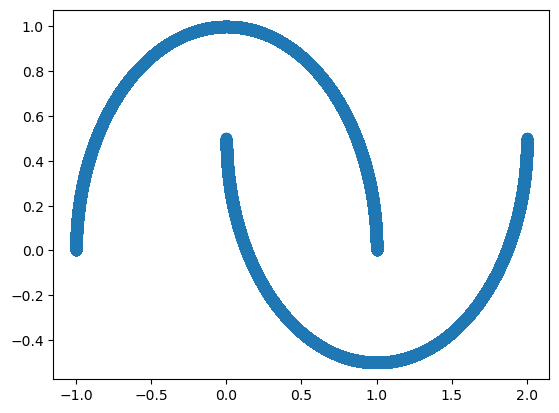

In [2]:

X, _ = make_moons(n_samples=300000, noise=0
            , random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
x0 = torch.tensor(X, dtype=torch.float32)

In [4]:
X

array([[-0.70995558,  0.70424646],
       [ 0.91777018,  0.39711195],
       [ 0.78771997,  0.61603348],
       ...,
       [-0.83957986,  0.54323628],
       [ 0.00117519,  0.45153342],
       [-0.78307886,  0.62192242]])

In [5]:
class Epsilon(nn.Module):
    """Neural network model for noise prediction"""

    def __init__(
        self,
        nfeatures,
        ntargets,
        nlayers,
        hidden_size,
        activation,
    ):
        super().__init__()
        layers = []

        # Input layer
        layer = nn.Linear(nfeatures, hidden_size)
        layers.append(layer)

        # Activation function for input layer
        layers.append(self._get_activation(activation))

        # Hidden layers
        for _ in range(nlayers - 1):
            layer = nn.Linear(hidden_size, hidden_size)
            layers.append(layer)
            layers.append(self._get_activation(activation))

        # Output layer
        layers.append(nn.Linear(hidden_size, ntargets))

        self.model = nn.Sequential(*layers)

    def _get_activation(self, activation):
        activations = {
            "LeakyReLU": nn.LeakyReLU(negative_slope=0.3),
            "ReLU": nn.ReLU(),
            "PReLU": nn.PReLU(),
            "ReLU6": nn.ReLU6(),
            "ELU": nn.ELU(),
            "SELU": nn.SELU(),
            "CELU": nn.CELU()
        }
        return activations.get(activation, nn.ReLU()) #default to ReLU if activation is not found

    def forward(self, x):
        return self.model(x)


There are many notations and interpretations in the literature for diffusion models. We use the one in [1]. Diffusion models are denoisers

- you start with an image $x_0$
- $x_T$ is the pure noise image, aka the latent space (same size as the original image), which is pure gaussian noise. 
- you add gaussian noise to it step by step
- $x_t$: noisy data at time step $t$
- you try to learn the model that goes in the opposite direction (i.e. removes the noise)
If you can do this well, then you can start with a pure noise image and denoise it to a clean realistic image. Or, if you have a low-quality image, you can denoise it to a high-quality image.

Following the diagram in [1]:

**REVERSE PROCESS (denoising)**: $x_T$ -> $x_{T-1}$ -> $x_{T-2}$ -> ... -> $x_0$ 
    This is described by 
    $$p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta\left(\mathbf{x}_t, t\right), \boldsymbol{\Sigma}_\theta\left(\mathbf{x}_t, t\right)\right)$$
    $$p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$$
    - here is where the learning happens. We want a model that can learn $x_{t-1} | x_t$, by learning the parameters of the gaussian distribution.

**FORWARD PROCESS (noising):** $x_T$ <- $x_{T-1}$ <- $x_{T-2}$ <- ... <- $x_0$ 
    This is described by 
    $$q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}\right)$$
    $$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_0\right):=\prod_{t=1}^T q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right)$$
- here you effectively shrink down the mean at each step, and add gaussian noise to the variance at each step.
    
- nothing to be learned here.
- $\beta_1, \ldots, \beta_T$ is the added noise at each time step, and $\alpha_t:=1-\beta_t$, $\bar
{\alpha}_t:=\prod_{s=1}^t \alpha_s$
- in the paper they choose $T=1000, \beta_1=10^{-4} \text { to } \beta_T=0.02$

```mermaid
graph TD;
    A-->B;
    A-->C;
    B-->D;
    C-->D;
```

## Training
repeat
1. $\mathbf{x}_0 \sim q\left(\mathbf{x}_0\right)$ (sample an image)
2. $t \sim \operatorname{Uniform}(\{1, \ldots, T\})$ (sample a time step)
3. $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ (sample gaussian noise)
4. create a an image with noise added to it: $ \mathbf{x}_t=\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}$
    
    - where $\beta_1, \ldots, \beta_T$ is the added noise at each time step, and $\alpha_t:=1-\beta_t$, $\bar{\alpha}_t:=\prod_{s=1}^t \alpha_s$.

5. Take gradient descent step on
$$\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2$$

- $\epsilon_\theta$ is a NN that tries to recover the noise that was applied $\epsilon$. This is equivalent to recovering the original image, because once you know what noise was applied to it, you can subtract it out from the noisy image and get the original image.

until converged


## Sampling (denoising, Langevin sampling)

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. for $t=T, T-1, \ldots, 1$ do
3. $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \text { if } t>1, \text { else } \mathbf{z}=\mathbf{0}$
4. $\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}$

where $\sigma_t = \sqrt{\beta_t}$

5. end for
6. return $\mathbf{x}_0$


## References

[1] Denoising Diffusion Probabilistic Models (DDPM, Jonathan Ho, Ajay Jain, Pieter Abbeel. NeurIPS 2020


In [7]:
# total time steps T
T=1000
# come up with noise scheduler beta_t, which goes from beta_1 to beta_T
beta_1=1E-4
beta_T=0.02
beta = torch.linspace(beta_1, beta_T, T)
alpha = 1 - beta
alpha

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994, 0.9994, 0.9994,
        0.9994, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9985, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983,
        0.9983, 0.9983, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9981, 0.9981,
        0.9981, 0.9981, 0.9981, 0.9980, 0.9980, 0.9980, 0.9980, 0.9980, 0.9979,
        0.9979, 0.9979, 0.9979, 0.9979, 0.9978, 0.9978, 0.9978, 0.9978, 0.9978,
        0.9977, 0.9977, 0.9977, 0.9977, 

In [8]:
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [9]:
def get_x_t(x0, t):
    """
    get the real image and the noise that was added to it at time t
    """
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0)
    epsilon = torch.randn_like(x0)
    xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * epsilon
    return xt, epsilon


t=0
plot_idx=0
t=100
plot_idx=1
t=200
plot_idx=2
t=300
plot_idx=3
t=400
plot_idx=4
t=500
plot_idx=5
t=600
plot_idx=6
t=700
plot_idx=7
t=800
plot_idx=8
t=900
plot_idx=9


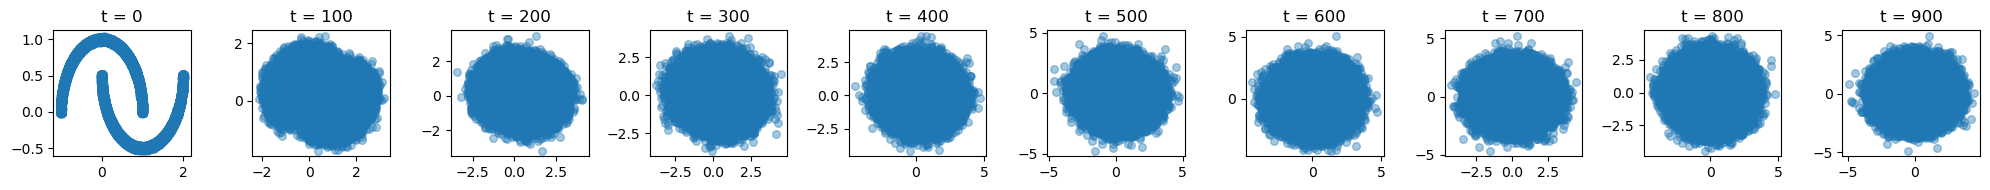

In [12]:
def plot_forward_xt(T_ex, x0, N_plots=10):
    fig, axs = plt.subplots(1,N_plots, figsize=(20, 2))
    den = T_ex / N_plots
    for t in range(0, T_ex):
        if t % den == 0:
            
            xt, epsilon = get_x_t(x0, t)
            plot_idx = int(t // den)
            
            print(f't={t}' \
            f'plot_idx={plot_idx}')
            axs[plot_idx].set_title(f't = {t}')
            axs[plot_idx].scatter(xt[:, 0], xt[:, 1], s=30, alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_forward_xt(T_ex=T, x0=x0, N_plots=10)

In [13]:
def sample_one_t():
    return torch.randint(low=1, high=T, size=(1,))

def sample_array_t(n):
    return torch.randint(low=1, high=T, size=(n,))
sample_one_t()

tensor([831])

In [14]:
sample_array_t(10)

tensor([ 83, 574, 533, 253, 468, 434, 871, 314,  19, 340])

In [15]:
def sample_one(model):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(x0.shape)
        for i in reversed(range(1, T)):
            t=i
            predicted_noise = model(x_t)
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            sigma_t = torch.sqrt(beta_t)
            
            if i > 1:
                z = torch.randn_like(x_t)
            else:
                z = torch.zeros_like(x_t)
                
            x_t = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/(torch.sqrt(1-alpha_t)) * predicted_noise ) + sigma_t * z
            
    model.train()
    return x_t


In [16]:
epsilon = Epsilon(nfeatures=2, ntargets=1, nlayers=2, hidden_size=100, activation='ReLU')
x0.shape

torch.Size([300000, 2])

In [17]:

def train(epochs=100):
    epsilon_theta = Epsilon(nfeatures=x0.shape[1], 
                            ntargets=1, 
                            nlayers=2, 
                            hidden_size=100, 
                            activation='ReLU')
    optimizer = optim.Adam(epsilon_theta.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()  # Renamed to avoid conflict
    for epoch in range(epochs):
        # t = sample_one_t() # uncomment to sample one t
        t = sample_array_t(x0.shape[1])
        optimizer.zero_grad()
        x_t, noise = get_x_t(x0, t) 
        predicted_noise = epsilon_theta(x_t)  # Added t parameter
        loss = loss_fn(predicted_noise, noise)  # Use renamed loss function
        loss.backward()
        optimizer.step()
    return epsilon_theta



In [19]:
epsilon_theta = train(epochs=100)


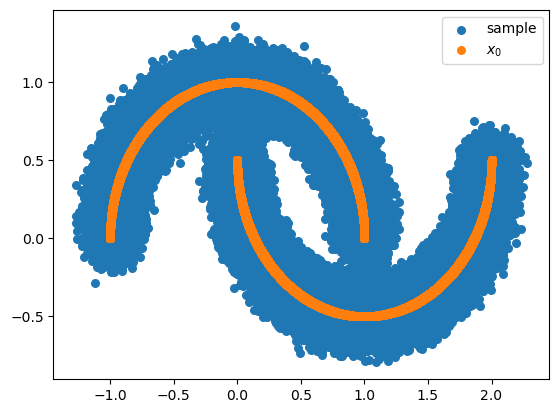

In [20]:
x_sample = sample_one(epsilon_theta)
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=30, label='sample');
plt.scatter(X[:, 0], X[:, 1], s=30, label='$x_0$');
plt.legend();

